In [1]:
import numpy as np
import pandas as pd
from numpy import nan

from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, BaggingRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier,  KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier,AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold,cross_val_score,StratifiedKFold
from sklearn.utils import resample
from sklearn.model_selection import train_test_split,cross_validate,cross_val_predict,RandomizedSearchCV
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,auc
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score,precision_recall_curve,accuracy_score,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold,RFECV
from imblearn.over_sampling import SMOTE,RandomOverSampler,ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2,mutual_info_classif
from sklearn.calibration import CalibratedClassifierCV,calibration_curve,CalibrationDisplay
from sklearn.metrics import multilabel_confusion_matrix
import xgboost as xgb
import os

#from sklego.meta import Thresholder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import cartopy.crs as ccrs

In [2]:
import rioxarray as rxr
import matplotlib.gridspec as gridspec
from metpy.plots import USCOUNTIES
import cartopy.feature as cfeature
import cartopy.crs as ccrs

In [3]:
codeDir = os.path.dirname(os.path.abspath(os.getcwd()))
parentDir = os.path.dirname(codeDir)

open training and label

In [10]:
df = pd.read_feather(parentDir+'\\train_test')

In [11]:
# remove samples where max mrms intensity < min possible gage intensity
min_int = pd.read_feather(parentDir+'\\min_intensity_gage')
min_int['gage_id'] = min_int.index
min_int.min_intensity = min_int.min_intensity
df['min_int'] = [min_int.loc[min_int.gage_id==df.gage_id[i][0]].min_intensity.values[0] for i in df.index]

df = df.query('max_mrms > min_int')

#df = df.reset_index(drop=True).drop(columns=['min_int','gage_id','max_accum_atgage'])
df = df.reset_index(drop=True).drop(columns=['min_int','max_accum_atgage'])
df.gage_id = [df.gage_id[i][0] for i in df.index]

In [12]:
# shift lon to 255.5, was 255 when i developed dataset
df = df.loc[df.longitude<255.5]

In [7]:
source = pd.read_csv(parentDir+'\\gage_source.csv',index_col=0)
source['gage_id'] = source.index

df['source'] = [source.loc[source.gage_id==df.gage_id[i]].source.values[0] for i in df.index]

In [8]:
df['label']=0
df.loc[df.mce>.1,['label']]=1
df = df.drop(columns=['gage_id','mrms_accum_atgage','gage_accum','mce','onoff']).dropna()

In [13]:
df.columns

Index(['gage_id', 'mrms_accum_atgage', 'gage_accum', 'total_accum_atgage',
       'onoff', 'mce', 'max_mrms', 'latitude', 'longitude', 'median_int_point',
       'std_int_point', 'var_int_point', 'mean_int_point',
       'median_accum_point', 'std_accum_point', 'var_accum_point',
       'mean_accum_point', 'duration', 'month', 'hour', 'mult_correct', 'RQI',
       'point_elev', 'point_slope', 'max', 'std', 'var', 'mean', 'median',
       'storm_elev', 'elevation_foot', 'slope_foot', 'point_aspect',
       'storm_aspect', 'accum_mean_storm', 'accum_max_storm',
       'accum_median_storm', 'accum_std_storm', 'accum_var_storm',
       'duration_storm', 'area', 'axis_major_length', 'axis_minor_length',
       'eccentricity', 'velocity'],
      dtype='object')

In [683]:
len(df.loc[(df.source=='csu')&(df.label==1)])/len(df.loc[(df.source=='csu')])

0.3870320855614973

In [684]:
len(df.loc[(df.source!='csu')&(df.label==1)])/len(df.loc[(df.source!='csu')])

0.2691150374199522

In [685]:
frac_pos

NameError: name 'frac_pos' is not defined

In [689]:
df.columns

Index(['total_accum_atgage', 'max_mrms', 'latitude', 'longitude',
       'median_int_point', 'std_int_point', 'var_int_point', 'mean_int_point',
       'median_accum_point', 'std_accum_point', 'var_accum_point',
       'mean_accum_point', 'duration', 'month', 'hour', 'mult_correct', 'RQI',
       'point_elev', 'point_slope', 'max', 'std', 'var', 'mean', 'median',
       'storm_elev', 'elevation_foot', 'slope_foot', 'point_aspect',
       'storm_aspect', 'accum_mean_storm', 'accum_max_storm',
       'accum_median_storm', 'accum_std_storm', 'accum_var_storm',
       'duration_storm', 'area', 'axis_major_length', 'axis_minor_length',
       'eccentricity', 'velocity', 'source', 'label'],
      dtype='object')

In [695]:
total = df.loc[(df.total_accum_atgage>1)].groupby(['latitude','longitude']).count().max_mrms
pos = df.loc[(df.total_accum_atgage>1)&(df.label==1)].groupby(['latitude','longitude']).count().max_mrms
freq = pos/total

In [696]:
freq = freq.reset_index()

In [697]:
freq = freq.fillna(0)

In [698]:
from scipy.interpolate import NearestNDInterpolator

f = NearestNDInterpolator(list(zip(freq.longitude, freq.latitude)), freq.max_mrms)

In [699]:
xnew = np.arange(predict.longitude.min(), predict.longitude.max(), .1)
ynew = np.arange(predict.latitude.min(), predict.latitude.max(), .1)
X,Y = np.meshgrid(xnew, ynew)
fnew = f(X,Y)

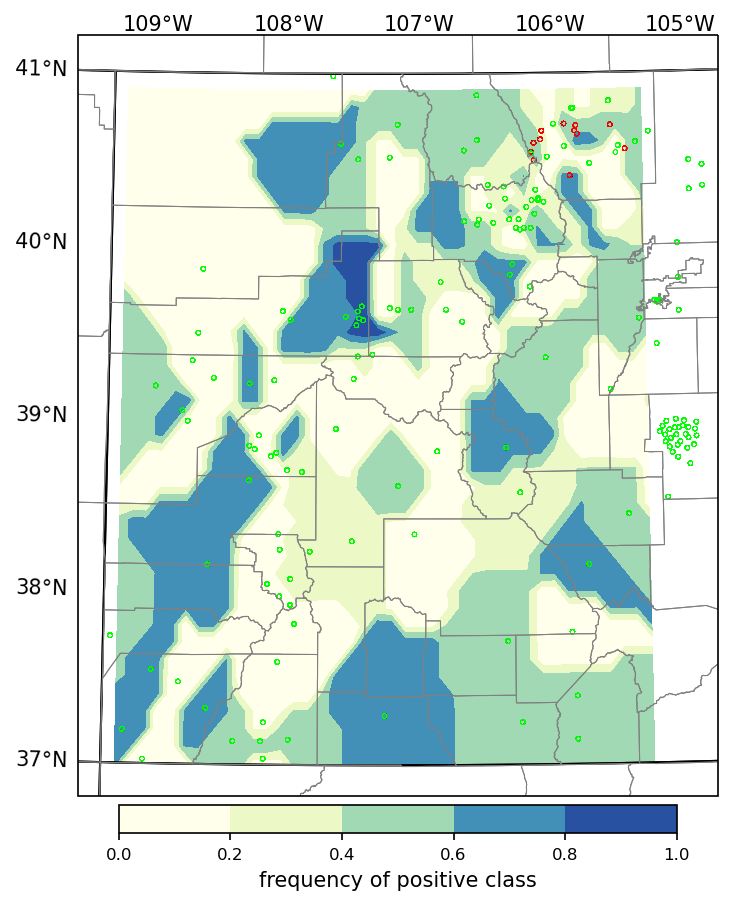

In [700]:

fig = plt.figure(1, figsize=(12,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)

plotcrs = ccrs.LambertConformal(central_latitude=38.5, central_longitude=-107)

ax = plt.subplot(1,1,1, projection=plotcrs)

# Set plot bounds -- or just comment this out if wanting to plot the full domain
ax.set_extent((-109.2, -104.6, 36.8, 41.2))

plt.rcParams['figure.dpi'] = 150

elev=ax.contourf(X,Y,fnew, cmap=cmap2,origin='upper', transform=ccrs.PlateCarree(),levels = list(np.arange(0,1.1,.2)))


cb =fig.colorbar(elev,orientation="horizontal", shrink=.4,pad=0.01)
cb.ax.tick_params(labelsize=8)
cb.set_label('frequency of positive class', fontsize=10)
#plt.title(title,size=20)
gage_source = gage_source.loc[gage_source.longitude<255.5]
ax.scatter(gage_source.loc[(gage_source.source=='csu')].longitude,gage_source.loc[(gage_source.source=='csu')].latitude,
           transform=ccrs.PlateCarree(),s = 5, color='r',facecolors='none',linewidth=.2)
ax.scatter(gage_source.loc[(gage_source.source!='csu')].longitude,gage_source.loc[(gage_source.source!='csu')].latitude,
           transform=ccrs.PlateCarree(),s = 5, color='lime',facecolors='none',linewidth=.2)


#elev2=ax.contourf(lon,lat,noband, levels=list(range(3000, 5000, 1000)), colors='fuchsia',origin='upper', 
                 #alpha=0.4,transform=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES, linewidth=1)

ax.add_feature(USCOUNTIES.with_scale('500k'), linewidth=0.5, edgecolor='gray')

gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  alpha=0, 
                  draw_labels=True, 
                  dms=True, 
                  x_inline=False, 
                  y_inline=False)
gl.xlabel_style = {'rotation':0}
# add these before plotting
gl.bottom_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels
fig.savefig('labeledmap.pdf',
           bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

In [496]:
f1 = []
precision = []
for i in np.arange(.1,.6,.1):
    for j in np.arange(.1,.8,.1):
        df['label']=0
        df.loc[df.mce>i,['label']]=1
        # look at RQI performance at several thresholds for mce
        df['rqi_label'] = 0
        df.loc[df.RQI>j,['rqi_label']]=1

        f1.append([i,j,f1_score(df.label,df.rqi_label)])
        precision.append([i,j,precision_score(df.label,df.rqi_label)])

In [497]:
f1 = pd.DataFrame(f1,columns=['mce','RQI','f1'])
precision = pd.DataFrame(precision,columns=['mce','RQI','precision'])

In [520]:
# model scores at different threshold values
f1_m = []
precision_m = []
for i in np.arange(.1,.6,.1):

    df['label']=0
    df.loc[df.mce>i,['label']]=1
    
    df_th = df.drop(columns=['gage_id','mrms_accum_atgage','gage_accum','mce','onoff']).dropna()
    
    pos_frac = len(df_th.loc[df_th.label==1])/len(df_th)
    
    # select gages for testing, weight number of samples so frac positive close to global frac pos
    test_s = df_th.groupby(['latitude','longitude']).count().total_accum_atgage
    test_s_pos = df_th.loc[df_th.label==1].groupby(['latitude','longitude']).count().total_accum_atgage
    test_s_pos_frac = test_s_pos/test_s
    # weight locations with frac pos closer to global frac pos higher
    weights = 1.0 / np.abs(pos_frac - test_s_pos_frac) 
    weights = weights.fillna(.5)

    # add loop to get proportion of pos to match
    test_s = test_s.sample(frac=.2,weights = weights,random_state=6).reset_index()


    test_lat,test_lon = test_s.latitude,test_s.longitude
    test = df_th.loc[(df_th.latitude.isin(test_lat))&(df_th.longitude.isin(test_lon))]
    train = df_th.loc[~df_th.index.isin(test.index)]
    print(len(test.loc[test.label==1])/len(test))
    print(len(train.loc[train.label==1])/len(train))

    train = train[selected_features_names]
    test = test[selected_features_names]
    
    scaler = StandardScaler()
    X_train, X_test, y_train, y_test = (scaler.fit_transform(train.drop(columns=['label'])),
    scaler.fit_transform(test.drop(columns=['label'])),
    train.label.values,
    test.label.values)
    
    clf.fit(X_train,y_train)
    
    f1_m.append([i,f1_score(y_test,clf.predict(X_test))])
    precision_m.append([i,precision_score(y_test,clf.predict(X_test))])
    
    

0.2837340876944837
0.2805347006042849
0.24364406779661016
0.24829135848703304
0.19606801275239108
0.2044328065089311
0.1166059344091619
0.15977390485162507
0.10196560196560196
0.08909918757253817


In [521]:
f1_m = pd.DataFrame(f1_m,columns=['mce','f1, model'])
precision_m = pd.DataFrame(precision_m,columns=['mce','precision, model'])

In [546]:
f1_m = f1_m.rename(columns={"f1": "f1, model"})

In [547]:
precision_m = precision_m.rename(columns={"precision": "precision, model"})

c:\temp\3\ipykernel_9376\3866678085.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0.1, 0.2, 0.3, 0.4, 0.5])


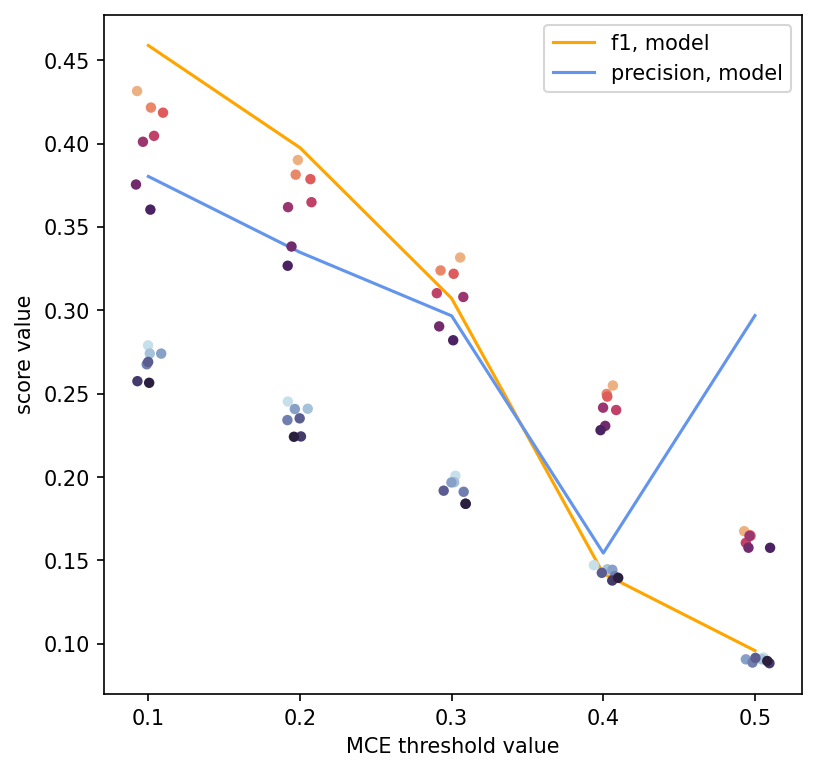

In [549]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.stripplot(data = f1, y='f1',x='mce',hue='RQI',palette = 'flare',legend=False)
sns.stripplot(data = precision, y='precision',x='mce',hue='RQI',palette ='ch:s=.25,rot=-.25' ,legend=False)
f1_m['f1, model'].plot(color='orange',legend = 'model')
precision_m['precision, model'].plot(color='cornflowerblue',legend = 'precision model')
ax.set_xticklabels([0.1, 0.2, 0.3, 0.4, 0.5])


plt.xlabel('MCE threshold value')
plt.ylabel('score value')
fig.savefig("RQI_mce.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

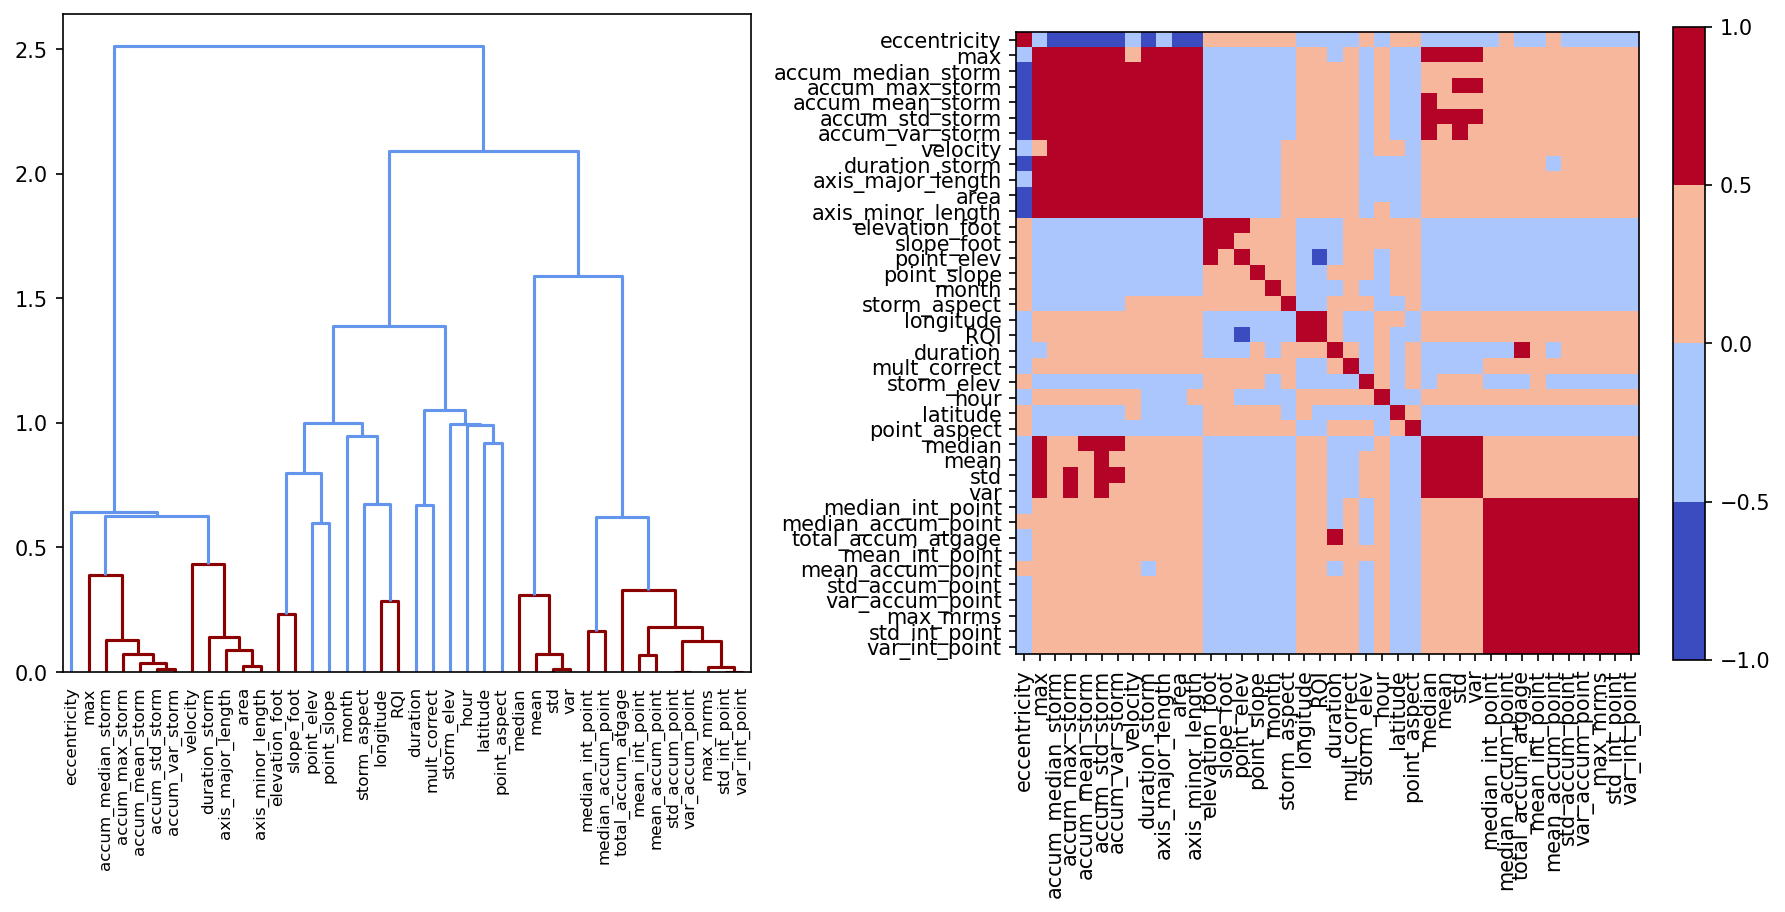

In [614]:
# look at correlated features
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
corr = spearmanr(df.drop(columns='label')).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
hierarchy.set_link_color_palette(['darkred'])

dendro = hierarchy.dendrogram(
    dist_linkage, color_threshold=.5,above_threshold_color='cornflowerblue',labels=df.drop(columns='label').columns.to_list(),
    ax=ax1, leaf_rotation=90
)

dendro_idx = np.arange(0, len(dendro["ivl"]))

import matplotlib as mpl
cmap = mpl.cm.coolwarm
bounds = [-1, -.5,0,.5, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=bounds,fraction=0.046)

im=ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]],cmap=cmap, norm=norm)

ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
#
_ = fig.tight_layout()
fig.savefig("corr_fea.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

In [9]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, .5, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

In [10]:
def display_menu(options):
    print("Menu:")
    for i, option in enumerate(options, start=1):
        print(f"{i}. {option}")
    print("Enter the number of your choice:")

def get_user_choice(options):
    display_menu(options)
    while True:
        try:
            choice = int(input())
            if 1 <= choice <= len(options):
                return choice
            else:
                print("Invalid choice. Please enter a valid number.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

In [19]:
selected_features=[]
for v in cluster_id_to_feature_ids.values():
    if len(v)==1:
        selected_features.append(v[0])
    else:
        options = df.drop(columns='label').columns[v]
        user_choice = get_user_choice(options)
        selected_features.append(v[user_choice-1])

Menu:
1. total_accum_atgage
2. max_mrms
3. std_int_point
4. var_int_point
5. mean_int_point
6. std_accum_point
7. var_accum_point
8. mean_accum_point
Enter the number of your choice:
2
Menu:
1. longitude
2. RQI
Enter the number of your choice:
2
Menu:
1. median_int_point
2. median_accum_point
Enter the number of your choice:
1
Menu:
1. max
2. accum_mean_storm
3. accum_max_storm
4. accum_median_storm
5. accum_std_storm
6. accum_var_storm
Enter the number of your choice:
4
Menu:
1. std
2. var
3. mean
4. median
Enter the number of your choice:
4
Menu:
1. elevation_foot
2. slope_foot
Enter the number of your choice:
2
Menu:
1. duration_storm
2. area
3. axis_major_length
4. axis_minor_length
5. velocity
Enter the number of your choice:
5


In [20]:
selected_features.append(40)

In [21]:
selected_features_names = df.columns[selected_features]

In [69]:
selected_features_names = selected_features_names.drop(labels=['latitude','point_aspect'])

In [597]:
selected_features_names

Index(['max_mrms', 'RQI', 'median_int_point', 'duration', 'month', 'hour',
       'mult_correct', 'point_elev', 'point_slope', 'accum_median_storm',
       'median', 'storm_elev', 'slope_foot', 'storm_aspect', 'velocity',
       'eccentricity', 'label'],
      dtype='object')

In [21]:
'''# look at RQI performance at several thresholds for mce
df['rqi_label'] = 0
df.loc[df.RQI>.5,['rqi_label']]=1
f1_score(df.label,df.rqi_label)'''

In [666]:
pos_frac

0.2813170090613544

In [642]:
pos_frac = len(df.loc[df.label==1])/len(df)
# select gages for testing, weight number of samples so frac positive close to global frac pos
test_s = df.groupby(['latitude','longitude']).count().total_accum_atgage
test_s_pos = df.loc[df.label==1].groupby(['latitude','longitude']).count().total_accum_atgage
test_s_pos_frac = test_s_pos/test_s
# weight locations with frac pos closer to global frac pos higher
weights = 1.0 / np.abs(pos_frac - test_s_pos_frac) 
weights = weights.fillna(.5)

# add loop to get proportion of pos to match
test_s = test_s.sample(frac=.2,weights = weights,random_state=6).reset_index()


test_lat,test_lon = test_s.latitude,test_s.longitude
test = df.loc[(df.latitude.isin(test_lat))&(df.longitude.isin(test_lon))]
train = df.loc[~df.index.isin(test.index)]
print(len(test.loc[test.label==1])/len(test))
print(len(train.loc[train.label==1])/len(train))


0.2837340876944837
0.2805347006042849


In [643]:
# manually set validation folds to separate gages
# do for cv
n_splits = 5
split_idx = []

train = train.reset_index(drop=True)
sample = train

for i in range(n_splits):

    # select gages for testing, weight number of samples so frac positive close to global frac pos
    test_s = sample.groupby(['latitude','longitude']).count().total_accum_atgage
    test_s_pos = sample.loc[sample.label==1].groupby(['latitude','longitude']).count().total_accum_atgage
    test_s_pos_frac = test_s_pos/test_s
    # weight locations with frac pos closer to global frac pos higher
    weights = 1.0 / np.abs(pos_frac - test_s_pos_frac) 
    weights = weights.fillna(5)

    split = test_s.sample(frac=1/(n_splits-i), weights=weights,random_state=4).reset_index()

    split_lat,split_lon = split.latitude,split.longitude
    
    split = sample.loc[(sample.latitude.isin(split_lat))&(sample.longitude.isin(split_lon))]
    
    split_idx.append(split.index)
    print(len(split.loc[split.label==1])/len(split))
    
    sample = sample.loc[~sample.index.isin(split.index)]


0.2517482517482518
0.28272827282728275
0.29720124389160374
0.3023770038695412
0.2698492462311558


In [644]:
train = train[selected_features_names]
test = test[selected_features_names]

In [557]:
folds = []

for i in range(n_splits):
    fold_test_idx = split_idx[i]
    fold_train_idx = train.loc[~train.index.isin(fold_test_idx)].index
    folds.append([fold_train_idx,fold_test_idx])

In [645]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = (scaler.fit_transform(train.drop(columns=['label'])),
scaler.fit_transform(test.drop(columns=['label'])),
train.label.values,
test.label.values)

cv = folds # is this indexing correctly????

test many models using defaults

In [565]:
names = [
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "Bagged Tree",
    "Neural Net",
    "AdaBoost",
    "Logistic Regression",
    "xgboost",
    "Gradient Boosting",
    "SVC"
]

In [74]:
names = [
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "Bagged Tree",
    "Neural Net",
    "AdaBoost",
    "Logistic Regression",
    "xgboost",
    "Gradient Boosting",
    "SVC"
]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    BaggingClassifier(random_state=0),
    MLPClassifier(random_state=0,max_iter=800),
    AdaBoostClassifier(random_state=0),
    LogisticRegression(random_state=0,max_iter=600),
    xgb.XGBClassifier(random_state=0),
    GradientBoostingClassifier(random_state=0),
    SVC(random_state=0,probability=True)
]

In [75]:
# baseline
avgp=[]
f1=[]

for name, clf in zip(names, classifiers):
    clf = clf

    x = cross_validate(clf,X_train,y_train, cv = cv,
                     scoring=['f1','average_precision'])

    f1.append([name,str(x['test_f1'].mean())[0:4], str(x['test_f1'].std())[0:6]])
    avgp.append([name,str(x['test_average_precision'].mean())[0:4],str(x['test_average_precision'].std())[0:6]])

In [76]:
f1_baseline = pd.DataFrame(f1,columns=['names','f1','std']).sort_values(['f1'])
avp_baseline = pd.DataFrame(avgp,columns=['names','avgp','std']).sort_values(['avgp'])


In [78]:
avp_baseline

,names,avgp,std
1,Decision Tree,0.30,0.0237
3,Bagged Tree,0.35,0.0369
0,Nearest Neighbors,0.36,0.0319
6,Logistic Regression,0.37,0.0467
4,Neural Net,0.39,0.0500
5,AdaBoost,0.39,0.0857
7,xgboost,0.39,0.0409
9,SVC,0.39,0.0463
8,Gradient Boosting,0.40,0.0750
2,Random Forest,0.41,0.0575


In [40]:
classifiers = [
    Pipeline([
        ('sampling', SMOTE(random_state=0)),
        ('clf', KNeighborsClassifier())
    ]),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    Pipeline([
        ('sampling', SMOTE(random_state=0)),
        ('clf', BaggingClassifier(random_state=0))
    ]),
    Pipeline([
        ('sampling', SMOTE(random_state=0)),
        ('clf', MLPClassifier(random_state=0,max_iter=800))
    ]),
    Pipeline([
        ('sampling', SMOTE(random_state=0)),
        ('clf', AdaBoostClassifier(random_state=0))
    ]),
    LogisticRegression(random_state=0,max_iter= 800),
    xgb.XGBClassifier(random_state=0),
    Pipeline([
        ('sampling', SMOTE(random_state=0)),
        ('clf', GradientBoostingClassifier(random_state=0))
    ]),
    SVC(random_state=0,probability=True)
]

In [41]:
# initial hyperparameter tuning
param = [
    # knn
    {'clf__n_neighbors': [2,3,5,8,10], 
     'clf__weights': ['uniform', 'distance'], 'clf__leaf_size':[10,20,30,50] },
    # dt
    {'max_depth': [5,10,20,30],'min_samples_split':[2,4,6,8],'min_samples_leaf':[1,2,4,6],
     'class_weight':['balanced',{0: 1.0, 1: 10.0},{0: 1.0, 1: 20.0},{0: 1.0, 1: 50.0}],
     'criterion':['gini','entropy','log_loss']},
    # RF
    {"n_estimators": [64, 100, 200,400], 
     'class_weight':['balanced',{0: 1.0, 1: 10.0},{0: 1.0, 1: 20.0},{0: 1.0, 1: 50.0}],
                                 "max_depth":[5,10,20,30],
                                          "min_samples_split":range(2,9),
                                         "min_samples_leaf":range(1,8)},
    # bagging
    {"clf__n_estimators": [64, 100, 200,400,600],'clf__max_samples':[1,3,5,8],'clf__max_features':[1,3,5,8]},
    # MLP
    {"clf__hidden_layer_sizes": [50,100,200,400], 
                                "clf__activation": ['identity', 'logistic', 'tanh', 'relu'],
                                          "clf__learning_rate_init":np.arange(0.0001,0.002,0.0003)},
    #Ada
    {'clf__n_estimators': [10,20,50,100], 'clf__learning_rate':[.01,.1,1,2]},
    
    # logistic
    {
     'class_weight':['balanced',{0: 1.0, 1: 10.0},{0: 1.0, 1: 20.0},{0: 1.0, 1: 50.0}]},
    #xgb
    {"learning_rate": [0.5, 0.25, 0.1, 0.05, 0.01,.001], 
                                "n_estimators": [64, 100, 200,400,600],
                                "max_depth":[5,10,20,30],
                                 'min_child_weight': [1, 5, 10],
                                 'gamma': [1, 1.5, 2, 5,6],
                                 'subsample': [0.6, 0.8, 1.0],
                                 'colsample_bytree': [0.6, 0.8, 1.0],
                                'scale_pos_weight':[10,20,30,50]},
    #gbc
    {"clf__learning_rate": [1, 0.5, 0.25, 0.1, 0.05, 0.01], 
                                "clf__n_estimators": [64, 100, 200,400],
                                "clf__max_depth":range(1,11),
                                          "clf__min_samples_split":range(2,8),
                                          "clf__min_samples_leaf":range(1,8)},
    # SVC
    {'C': [0.1, 1, 10, 100],'class_weight':['balanced',{0: 1.0, 1: 10.0},{0: 1.0, 1: 20.0},{0: 1.0, 1: 50.0}],
     'kernel':['linear', 'poly', 'rbf', 'sigmoid']} 
]

In [42]:
hyp = []
for name, clf, param in zip(names, classifiers, param):

    clf = clf

    mod = RandomizedSearchCV(estimator=clf,
                       param_distributions = param,
                       n_iter=10, 
                       scoring=['average_precision',"f1",'precision','recall'],
                       refit="average_precision",
                       cv=cv)

    _ = mod.fit(X_train,y_train)  

    hyp.append([name, 
                pd.DataFrame(mod.cv_results_).sort_values('mean_test_average_precision',
                                                          ascending=False).iloc[0].params,
                               pd.DataFrame(mod.cv_results_).sort_values('mean_test_average_precision',
                                                          ascending=False).iloc[0].mean_test_average_precision,
                                              pd.DataFrame(mod.cv_results_).sort_values('mean_test_average_precision',
                                                          ascending=False).iloc[0].mean_test_f1,
               pd.DataFrame(mod.cv_results_).sort_values('mean_test_average_precision',
                                                          ascending=False).iloc[0].mean_test_precision,
               pd.DataFrame(mod.cv_results_).sort_values('mean_test_average_precision',
                                                          ascending=False).iloc[0].mean_test_recall])

C:\Users\whitep\AppData\Local\miniconda3\envs\radar\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\whitep\AppData\Local\miniconda3\envs\radar\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\whitep\AppData\Local\miniconda3\envs\radar\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\whitep\AppData\Local\minicon

In [43]:
out=pd.DataFrame(hyp,columns=['names','param','avg_p','f1','precision','recall'])

In [44]:
out.to_csv('parameter_tune')

In [56]:
out

,names,param,avg_p,f1,precision,recall
0,Nearest Neighbors,"{'clf__weights': 'distance', 'clf__n_neighbors...",0.382558,0.450263,0.359366,0.604500
1,Decision Tree,"{'min_samples_split': 6, 'min_samples_leaf': 6...",0.330871,0.437153,0.285907,0.930837
2,Random Forest,"{'n_estimators': 400, 'min_samples_split': 5, ...",0.410296,0.439544,0.398977,0.490838
3,Bagged Tree,"{'clf__n_estimators': 200, 'clf__max_samples':...",0.352500,0.431548,0.322049,0.678745
4,Neural Net,"{'clf__learning_rate_init': 0.0007, 'clf__hidd...",0.386980,0.440020,0.368132,0.556226
5,AdaBoost,"{'clf__n_estimators': 100, 'clf__learning_rate...",0.410178,0.455193,0.384729,0.561584
6,Logistic Regression,{'class_weight': 'balanced'},0.382413,0.441278,0.361761,0.573265
7,xgboost,"{'subsample': 0.6, 'scale_pos_weight': 50, 'n_...",0.418369,0.465261,0.319522,0.857569
8,Gradient Boosting,"{'clf__n_estimators': 200, 'clf__min_samples_s...",0.438172,0.471405,0.410146,0.559377
9,SVC,"{'kernel': 'linear', 'class_weight': 'balanced...",0.378083,0.436837,0.359627,0.564331


In [22]:
out=pd.read_csv('parameter_tune',index_col=0)

In [47]:
def strip(d):
    d = {key.replace('clf__', ''):value for key, value in d.items()}
    return d

In [24]:
out['param'] = [eval(out['param'][i]) for i in out.index]

In [566]:
# add parameters to model

classifiers = [
    Pipeline([
        ('sampling', SMOTE(random_state=0)),
        ('clf', KNeighborsClassifier(**strip(out['param'][0])))
    ]),
    
    DecisionTreeClassifier(random_state=0,**out['param'][1]),
    RandomForestClassifier(random_state=0,**out['param'][2]),
    Pipeline([
        ('sampling', SMOTE(random_state=0)),
        ('clf', BaggingClassifier(random_state=0,**strip(out['param'][3])))
    ]),
    Pipeline([
        ('sampling', SMOTE(random_state=0)),
        ('clf', MLPClassifier(random_state=0,max_iter=800,**strip(out['param'][4])))]),
        
    Pipeline([
        ('sampling', SMOTE(random_state=0)),
        ('clf', AdaBoostClassifier(random_state=0,**strip(out['param'][5])))
    ]),

    LogisticRegression(random_state=0,max_iter=800,**out['param'][6]),
    xgb.XGBClassifier(random_state=0,**out['param'][7]),
    Pipeline([
        ('sampling', SMOTE(random_state=0)),
        ('clf', GradientBoostingClassifier(random_state=0,**strip(out['param'][8])))
    ]),

    SVC(random_state=0,probability=True,**out['param'][9])]

In [81]:
# get std dev
avgp=[]
f1=[]

for name, clf in zip(names, classifiers):
    clf = clf

    x = cross_validate(clf,X_train,y_train, cv = cv,
                     scoring=['f1','average_precision'])

    f1.append([name,str(x['test_f1'].mean())[0:6], str(x['test_f1'].std())[0:6]])
    avgp.append([name,str(x['test_average_precision'].mean())[0:6],str(x['test_average_precision'].std())[0:6]])

In [559]:
avp_hyp = pd.DataFrame(avgp,columns=['names','avgp','std'])

In [560]:
avp_hyp

,names,avgp,std
0,Nearest Neighbors,0.38,0.0417
1,Decision Tree,0.30,0.0203
2,Random Forest,0.41,0.0585
3,Bagged Tree,0.30,0.0382
4,Neural Net,0.37,0.0456
5,AdaBoost,0.39,0.0748
6,Logistic Regression,0.37,0.0467
7,xgboost,0.41,0.0648
8,Gradient Boosting,0.40,0.0521
9,SVC,0.37,0.0460


In [87]:
avp_hyp

,names,avgp,std
1,Decision Tree,0.30,0.0203
3,Bagged Tree,0.30,0.0382
4,Neural Net,0.37,0.0456
6,Logistic Regression,0.37,0.0467
9,SVC,0.37,0.0460
0,Nearest Neighbors,0.38,0.0417
5,AdaBoost,0.39,0.0748
8,Gradient Boosting,0.40,0.0521
2,Random Forest,0.41,0.0585
7,xgboost,0.41,0.0648


In [568]:
ap = []
f1 = []
p = []
r = []
pos = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train,y_train)
    ap.append([name,average_precision_score(y_test,clf.predict_proba(X_test)[:,1])])
    f1.append([name,f1_score(y_test,clf.predict(X_test))])
    p.append([name,precision_score(y_test,clf.predict(X_test))])
    r.append([name,recall_score(y_test,clf.predict(X_test))])
    count = np.sum(clf.predict(predict_s)==1)
    pos.append([name,count/len(predict_s)])

In [569]:
ap = pd.DataFrame(ap,columns=['names','avgp'])
f1 = pd.DataFrame(f1,columns=['names','f1'])
p = pd.DataFrame(p,columns=['names','p'])
r = pd.DataFrame(r,columns=['names','r'])
pos = pd.DataFrame(pos,columns=['names','pos'])

In [570]:
pd.concat([ap,f1,p,r,pos],axis=1)

,names,avgp,names,f1,names,p,names,r,names,pos
0,Nearest Neighbors,0.379117,Nearest Neighbors,0.449153,Nearest Neighbors,0.365976,Nearest Neighbors,0.581256,Nearest Neighbors,0.488720
1,Decision Tree,0.306037,Decision Tree,0.448854,Decision Tree,0.294118,Decision Tree,0.947159,Decision Tree,0.922813
2,Random Forest,0.403621,Random Forest,0.458861,Random Forest,0.380328,Random Forest,0.578265,Random Forest,0.457724
3,Bagged Tree,0.345979,Bagged Tree,0.413160,Bagged Tree,0.335196,Bagged Tree,0.538385,Bagged Tree,0.455809
4,Neural Net,0.350664,Neural Net,0.418680,Neural Net,0.351114,Neural Net,0.518445,Neural Net,0.417163
5,AdaBoost,0.344977,AdaBoost,0.448285,AdaBoost,0.303977,AdaBoost,0.853440,AdaBoost,0.748216
6,Logistic Regression,0.349023,Logistic Regression,0.423821,Logistic Regression,0.346178,Logistic Regression,0.546361,Logistic Regression,0.446757
7,xgboost,0.391877,xgboost,0.448555,xgboost,0.300714,xgboost,0.882353,xgboost,0.861391
8,Gradient Boosting,0.351236,Gradient Boosting,0.441229,Gradient Boosting,0.284036,Gradient Boosting,0.988036,Gradient Boosting,0.956195
9,SVC,0.349651,SVC,0.420121,SVC,0.352227,SVC,0.520439,SVC,0.428229


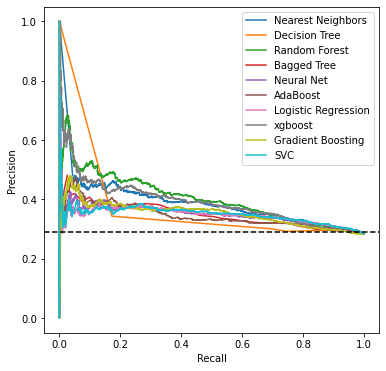

In [88]:
# look at PR curves to help choose model
# add AP and std to label
fig, ax = plt.subplots(figsize=(6, 6))
for name, clf in zip(names, classifiers):

    #y_probas = cross_val_predict(clf,X_train,y_train,cv=cv,method='predict_proba')
    clf.fit(X_train,y_train)
    p,r, thresholds = precision_recall_curve(y_test,clf.predict_proba(X_test)[:,1])
    
    ax.plot(r,p, label=name)
    ax.legend(loc="upper right")
    
    
    plt.ylabel("Precision")
    plt.xlabel("Recall")
plt.axhline(y=.29,color='k',linestyle='--',label = 'chance level') 
fig.savefig("pr_curve_all.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')


In [687]:
# add parameters to model
names = [
    "Nearest Neighbors",
    
    "Random Forest",
    
    "xgboost",

]
# add parameters to model

classifiers = [
    Pipeline([
        ('sampling', SMOTE(random_state=0)),
        ('clf', KNeighborsClassifier(**strip(out['param'][0])))
    ]),
    
    
    RandomForestClassifier(random_state=0,**out['param'][2]),
    
    xgb.XGBClassifier(random_state=0,**out['param'][7]),
    Pipeline([
        ('sampling', SMOTE(random_state=0)),
        ('clf', GradientBoostingClassifier(random_state=0,**strip(out['param'][8])))
    ]),
]

In [686]:
name

'SVC'

0.08279348520884708
0.04926623991568423
0.13467648856634962


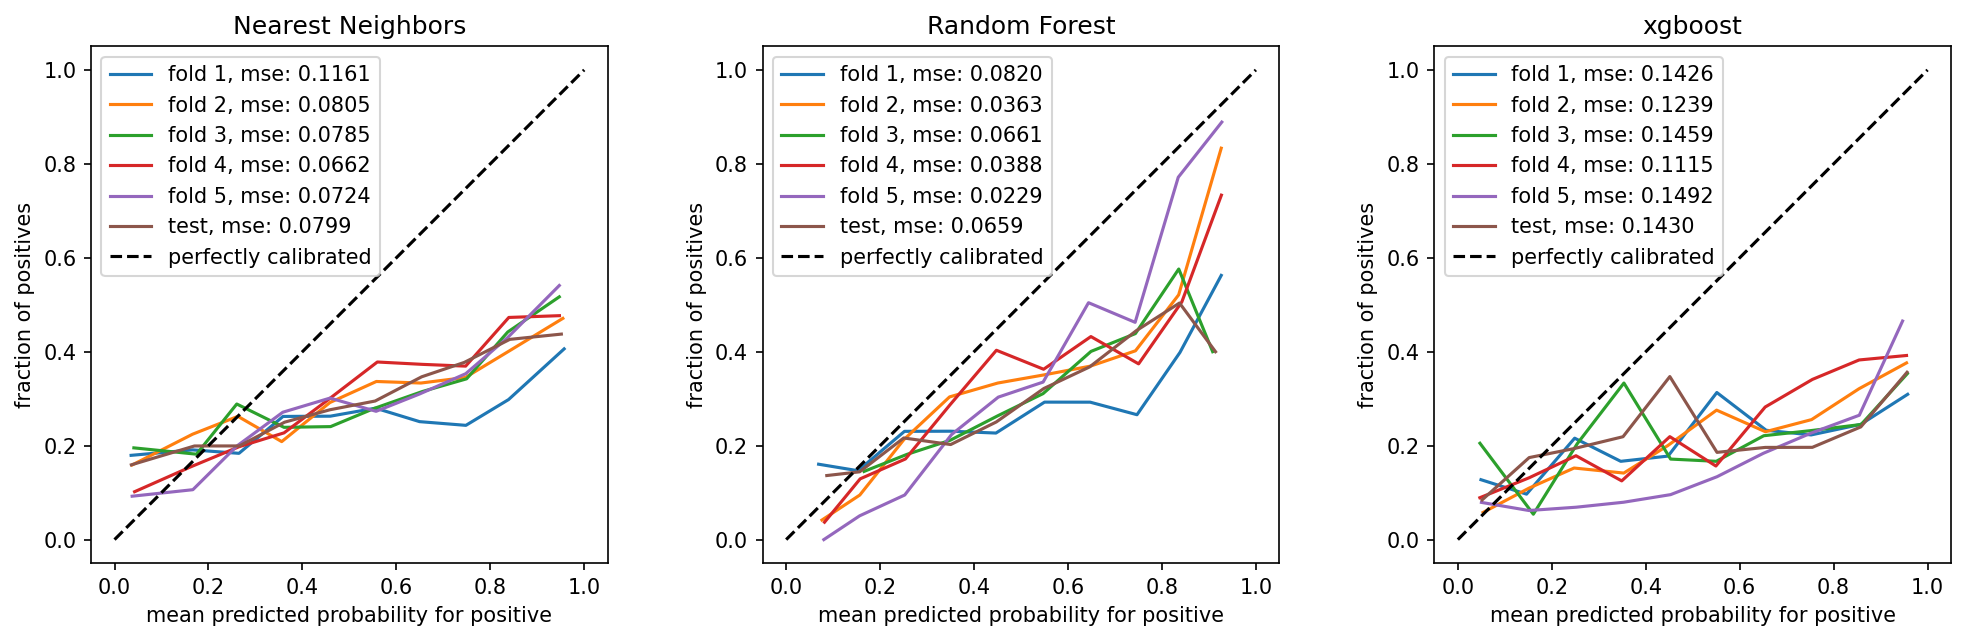

In [688]:
fig, axs = plt.subplots(1,3, figsize=(16,12), facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace=.3)

axs = axs.ravel() 
j=0

for name, clf in zip(names, classifiers):
    mse_c=[]
    for i in range(5):
        model = clf.fit(X_train[cv[i][0]],y_train[cv[i][0]]) 
        y_prob = model.predict_proba(X_train[cv[i][1]])[:,1]
        prob_true, prob_pred = calibration_curve(y_train[cv[i][1]], y_prob, n_bins=10)
        mse = mean_squared_error(prob_true,prob_pred)
        axs[j].plot(prob_pred,prob_true,label='fold '+str(i+1)+', mse: '+str(mse)[0:6])
        mse_c.append(mse)
        
    print(np.mean(mse_c))
    clf.fit(X_train,y_train)

    y_prob = clf.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

    mse = mean_squared_error(prob_true,prob_pred)
    axs[j].plot(prob_pred,prob_true,label='test, mse: '+str(mse)[0:6])

    axs[j].set_title(name)
    
    axs[j].plot([0,1],[0,1],'--k',label='perfectly calibrated')
    axs[j].legend()
    axs[j].axis("square")
    axs[j].set_xlabel('mean predicted probability for positive')
    axs[j].set_ylabel('fraction of positives')
    j+=1
fig.savefig("calibration.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

In [626]:
# add parameters to model
names = [

    
    "Random Forest",


]
# add parameters to model

classifiers = [

    
    
    RandomForestClassifier(random_state=0,**out['param'][2]),

]

0.4156119971479206
0.05851692968665632


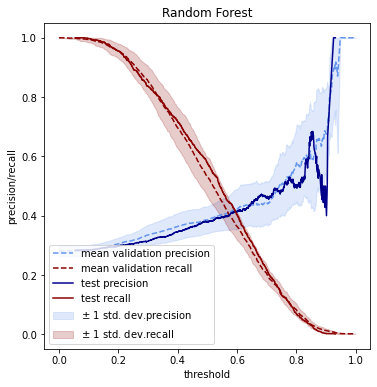

In [92]:
fig, axs = plt.subplots(1,1, figsize=(8,6), facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace=.3)


for name, clf in zip(names, classifiers):
    mean_t = np.linspace(0, 1, 1500)
    ap = []
    r = []
    p = []
    for i in range(5):
        model = clf.fit(X_train[cv[i][0]],y_train[cv[i][0]]) 
        y_prob = model.predict_proba(X_train[cv[i][1]])[:,1]
        precision, recall, thresholds = precision_recall_curve(y_train[cv[i][1]], y_prob)
        p.append(np.interp(mean_t, thresholds, precision[:-1]))
        r.append(np.interp(mean_t, thresholds, recall[:-1]))
        
        ap.append(average_precision_score(y_train[cv[i][1]], y_prob))

    mean_p = np.mean(p, axis=0)
    std_p = np.std(p, axis=0)
    mean_r = np.mean(r, axis=0)
    std_r = np.std(r, axis=0)
    mean_ap = np.mean(ap)
    
    std_ap = np.std(ap)
    print(mean_ap)
    print(std_ap)
    axs.plot(mean_t,mean_p,label='mean validation precision', color='cornflowerblue',linestyle='--')
    axs.plot(mean_t,mean_r,label='mean validation recall',color='darkred',linestyle='--')

    clf = clf.fit(X_train,y_train)
    y_prob = clf.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    axs.plot(thresholds,precision[:-1],label='test precision', color='darkblue')
    axs.plot(thresholds,recall[:-1],label='test recall',color='darkred')
    
    axs.axis("square")
    axs.set_title(name)
    axs.set_xlabel("threshold")
    axs.set_ylabel("precision/recall")

    p_upper = np.minimum(mean_p + std_p, 1)
    p_lower = np.maximum(mean_p - std_p, 0)
    axs.fill_between(
        mean_t,
        p_lower,
        p_upper,
        color="cornflowerblue",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev."+'precision',
    )

    r_upper = np.minimum(mean_r + std_r, 1)
    r_lower = np.maximum(mean_r - std_r, 0)
    axs.fill_between(
        mean_t,
        r_lower,
        r_upper,
        color="darkred",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev."+'recall',
    )
    axs.legend(loc="lower left")

fig.savefig("PR.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

In [95]:
# recursive feature search for models that have feature importance
min_features_to_select = 5  # Minimum number of features to consider
n_scores = []
ts=[]
std_ts=[]
fi_preht = []
optimal_num = []
index = df[selected_features_names].drop(columns=['label']).columns
for name, clf in zip(names, classifiers):

    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="average_precision",
        # scoring="accuracy",
        min_features_to_select=min_features_to_select,
        n_jobs=2,
        #importance_getter='coef_'
    )
    rfecv.fit(X_train,y_train)
    feature_importances = pd.DataFrame(rfecv.estimator_.feature_importances_,
                                   index = index[rfecv.get_support()],
                                   columns=[name+'prefsimportance']).sort_values(name+'prefsimportance',
                                                                       ascending=False)

    fi_preht.append(feature_importances)

    optimal_num.append(rfecv.n_features_)

    n_scores.append(len(rfecv.cv_results_["mean_test_score"]))
    ts.append(rfecv.cv_results_["mean_test_score"])
    std_ts.append(rfecv.cv_results_["std_test_score"])

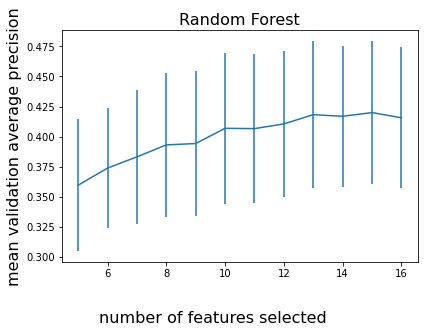

In [112]:
fig, axs = plt.subplots(1,1, figsize=(6,4), facecolor='w', edgecolor='k',sharey=True,sharex=True)
 
fig.subplots_adjust(wspace=.3)
   

fig.text(0.5,-.1, "number of features selected", ha="center", va="center",fontsize=16)
for i,name in enumerate(names):   
    #axs[i].set_xlabel("number of features selected")

    axs.errorbar(
        range(min_features_to_select, n_scores[i] + min_features_to_select),
        ts[i],
        yerr=std_ts[i],
    )
    axs.set_title(name, fontsize=16)
axs.set_ylabel("mean validation average precision", fontsize=16)  

fig.tight_layout()
    
fig.savefig("rfecv.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

In [268]:
index = df[selected_features_names].drop(columns=['label']).columns
# look at test feature importance
all_values = []
for name, clf in zip(names, classifiers):

    clf = clf.fit(X_train,y_train)
    result = permutation_importance(
        clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2, scoring='average_precision'
    )

    sorted_importances_idx = result.importances_mean.argsort()
    importances1 = pd.DataFrame(
        result.importances[sorted_importances_idx].T,

        columns=index[sorted_importances_idx],
    )
    
    r_all_values = []
    r_mean = []
    for i in range(5):
        model = clf.fit(X_train[cv[i][0]],y_train[cv[i][0]]) 

        r = permutation_importance(
            model, X_train[cv[i][1]], y_train[cv[i][1]], n_repeats=10, random_state=42, n_jobs=2, scoring='average_precision'
        )
        r_mean.append(r.importances_mean)
        r_all_values.append(r.importances)

    result = np.mean(r_mean,axis=0)
    all_values=np.mean(r_all_values,axis=0)
    
    importances2 = pd.DataFrame(
        
        all_values[sorted_importances_idx].T,
        columns=index[sorted_importances_idx],
    )
    
    rf_fi = clf.feature_importances_[sorted_importances_idx]

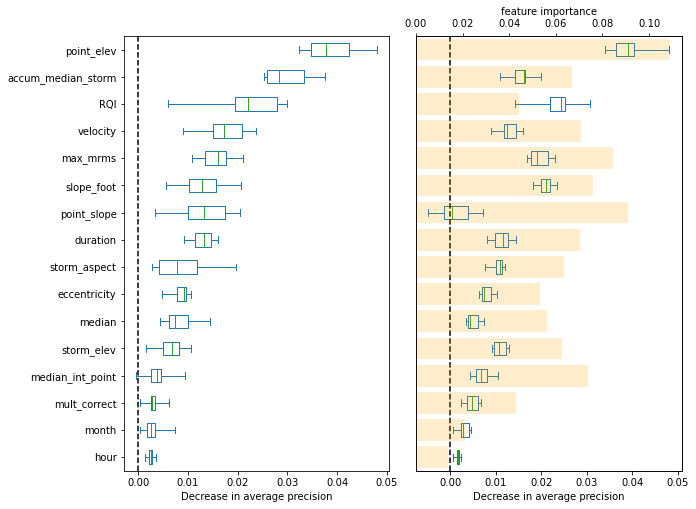

In [282]:
fig, axs = plt.subplots(1,2, figsize=(10,8), facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace=.1)
i=0
axs = axs.ravel() 
for name, clf in zip(names, classifiers):

    importances1.plot.box(vert=False, whis=10,ax=axs[i])
    axs[i].axvline(x=0, color="k", linestyle="--")
    axs[i].set_xlabel("Decrease in average precision")
    #axs[i].set_title("Permutation importance test")
    i+=1
    importances2.plot.box(vert=False, whis=10,ax=axs[i])
    axs[i].set_yticks([])  
    ax2 = axs[i].twiny()
    ax2.barh(np.arange(0,len(sorted_importances_idx))+1,rf_fi,alpha=.2,color='orange')
    axs[i].axvline(x=0, color="k", linestyle="--")
    ax2.set_xlabel('feature importance')
    axs[i].set_xlabel("Decrease in average precision")
    #axs[i].set_title("Permutation importance validation")


fig.savefig("featureimportance.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

In [283]:
# are models predicting same proportion of positive class
predict = pd.read_feather(parentDir+'\\predict')

predict = predict.rename(columns={'correction':'mult_correct'})
predict=predict.reindex(columns=df[selected_features_names].drop(columns=['label']).columns)

predict=predict.dropna()
#predict=predict.loc[predict.max_mrms>1]

predict_s =scaler.fit_transform(predict)

In [285]:
model = clf.fit(X_train,y_train)

predict['label_rf'] = model.predict(predict_s)
predict['prob_rf'] = model.predict_proba(predict_s)[:,1]

#model = classifiers[1].fit(X_train,y_train)
#predict['label_xg'] = model.predict(predict_s)
#predict['prob_xg'] = model.predict_proba(predict_s)[:,1]

In [286]:
print(len(predict.loc[predict.label_rf==1])/len(predict))
#print(len(predict.loc[predict.label_xg==1])/len(predict))

0.457724421064951


In [211]:
print(len(predict.loc[predict.label_rf==1])/len(predict))
print(len(predict.loc[predict.label_xg==1])/len(predict))

0.2566748077402823
0.4280562134460148


In [406]:
predict.to_feather('predict_labeled')

In [ ]:
# save

In [287]:
predict['longitude'] = pd.read_feather(parentDir+'\\predict').longitude

In [288]:
predict['latitude'] = pd.read_feather(parentDir+'\\predict').latitude

In [289]:
predict['total_accum_atgage'] = pd.read_feather(parentDir+'\\predict').total_accum_atgage

In [290]:
# how many samples per grid
count = predict.loc[predict.total_accum_atgage>1].groupby(['latitude','longitude']).count().max_mrms
#count = predict.groupby(['latitude','longitude']).count().max_mrms
# frequency of positive label
count_pos = predict.loc[(predict.label_rf==1)&(predict.total_accum_atgage>1)].groupby(['latitude','longitude']).count().max_mrms
#count_pos = predict.loc[(predict.label==1)].groupby(['latitude','longitude']).count().max_mrms
freq_pos = (count_pos/count).to_xarray()
count = count.to_xarray()

In [ ]:
'accum_median_storm', 'slope_foot','max_mrms

In [498]:
# how many samples per grid
low = predict.loc[(predict.prob_rf<.3)&(predict.total_accum_atgage>1)].groupby(['latitude','longitude']).median().accum_median_storm
high = predict.loc[(predict.prob_rf>.7)&(predict.total_accum_atgage>1)].groupby(['latitude','longitude']).median().accum_median_storm
low = low.to_xarray()
high = high.to_xarray()

In [293]:
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
from metpy.plots import USCOUNTIES
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [317]:
# how many samples per grid
count = predict.loc[predict.total_accum_atgage>1].groupby(['latitude','longitude']).count().max_mrms
#count = predict.groupby(['latitude','longitude']).count().max_mrms
# frequency of positive label
rqi_pos = predict.loc[(predict.RQI>.5)&(predict.total_accum_atgage>1)].groupby(['latitude','longitude']).count().max_mrms
#count_pos = predict.loc[(predict.label==1)].groupby(['latitude','longitude']).count().max_mrms
rqi_freq = (rqi_pos/count).to_xarray()
count = count.to_xarray()

In [505]:
test = high.fillna(0)
title = "median storm accumulation pp > 70% \n median value for coordinate"
levels = list(np.arange(0,3,.3))

In [394]:
test = freq_pos.fillna(0)
title = "frequency of positive class"
levels = list(np.arange(0,1.1,.2))
filename = 'freq'

In [294]:
cmap_data = [(255,255,255),

(255,255,204),
(161,218,180),
#(65,182,196),
(44,127,184),
(37,52,148)]

cmap_data_N=[]
for i in cmap_data:
    cmap_data_N.append([c/255 for c in i])

cmap2 = LinearSegmentedColormap.from_list('custom',cmap_data_N)

In [320]:
source = pd.read_csv(parentDir+'\\gage_source.csv',index_col=0)
source['gage_id'] = source.index

df['source'] = [source.loc[source.gage_id==df.gage_id[i][0]].source.values[0] for i in df.index]

gage_source = df[['source','latitude','longitude']]


In [485]:
levels = list(np.arange(0,10,2))


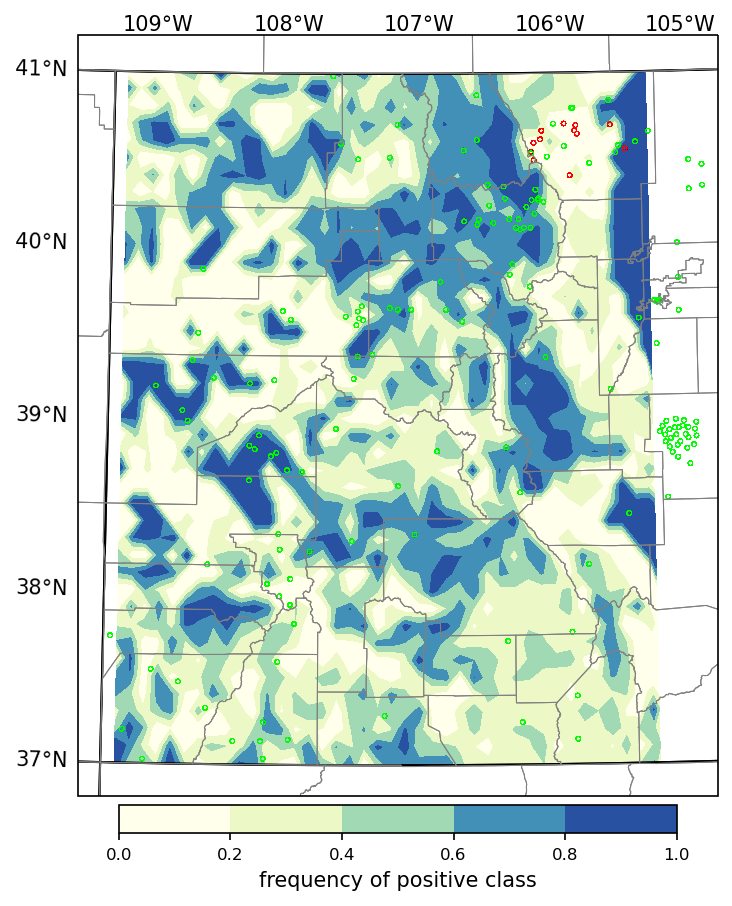

In [395]:
fig = plt.figure(1, figsize=(12,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)

plotcrs = ccrs.LambertConformal(central_latitude=38.5, central_longitude=-107)

ax = plt.subplot(1,1,1, projection=plotcrs)

# Set plot bounds -- or just comment this out if wanting to plot the full domain
ax.set_extent((-109.2, -104.6, 36.8, 41.2))

plt.rcParams['figure.dpi'] = 150

elev=ax.contourf(count.longitude, count.latitude,test, cmap=cmap2,origin='upper', transform=ccrs.PlateCarree(), levels=levels)
            #,levels=[0,0.1,.2,.3,.4,.5])#,levels=[count.min(),20,50,100,200,count.max()])
cb =fig.colorbar(elev,orientation="horizontal", shrink=.4,pad=0.01)
cb.ax.tick_params(labelsize=8)
cb.set_label(title, fontsize=10)
#plt.title(title,size=20)
gage_source = gage_source.loc[gage_source.longitude<255.5]
ax.scatter(gage_source.loc[(gage_source.source=='csu')].longitude,gage_source.loc[(gage_source.source=='csu')].latitude,
           transform=ccrs.PlateCarree(),s = 5, color='r',facecolors='none',linewidth=.2)
ax.scatter(gage_source.loc[(gage_source.source!='csu')].longitude,gage_source.loc[(gage_source.source!='csu')].latitude,
           transform=ccrs.PlateCarree(),s = 5, color='lime',facecolors='none',linewidth=.2)


#elev2=ax.contourf(lon,lat,noband, levels=list(range(3000, 5000, 1000)), colors='fuchsia',origin='upper', 
                 #alpha=0.4,transform=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES, linewidth=1)

ax.add_feature(USCOUNTIES.with_scale('500k'), linewidth=0.5, edgecolor='gray')

gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  alpha=0, 
                  draw_labels=True, 
                  dms=True, 
                  x_inline=False, 
                  y_inline=False)
gl.xlabel_style = {'rotation':0}
# add these before plotting
gl.bottom_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels
fig.savefig(filename+'.pdf',
           bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

move thresold to increase precision

roc curve

confusion matrix

[[1587  945]
 [ 423  580]]
[0.627 0.373 0.422 0.578]


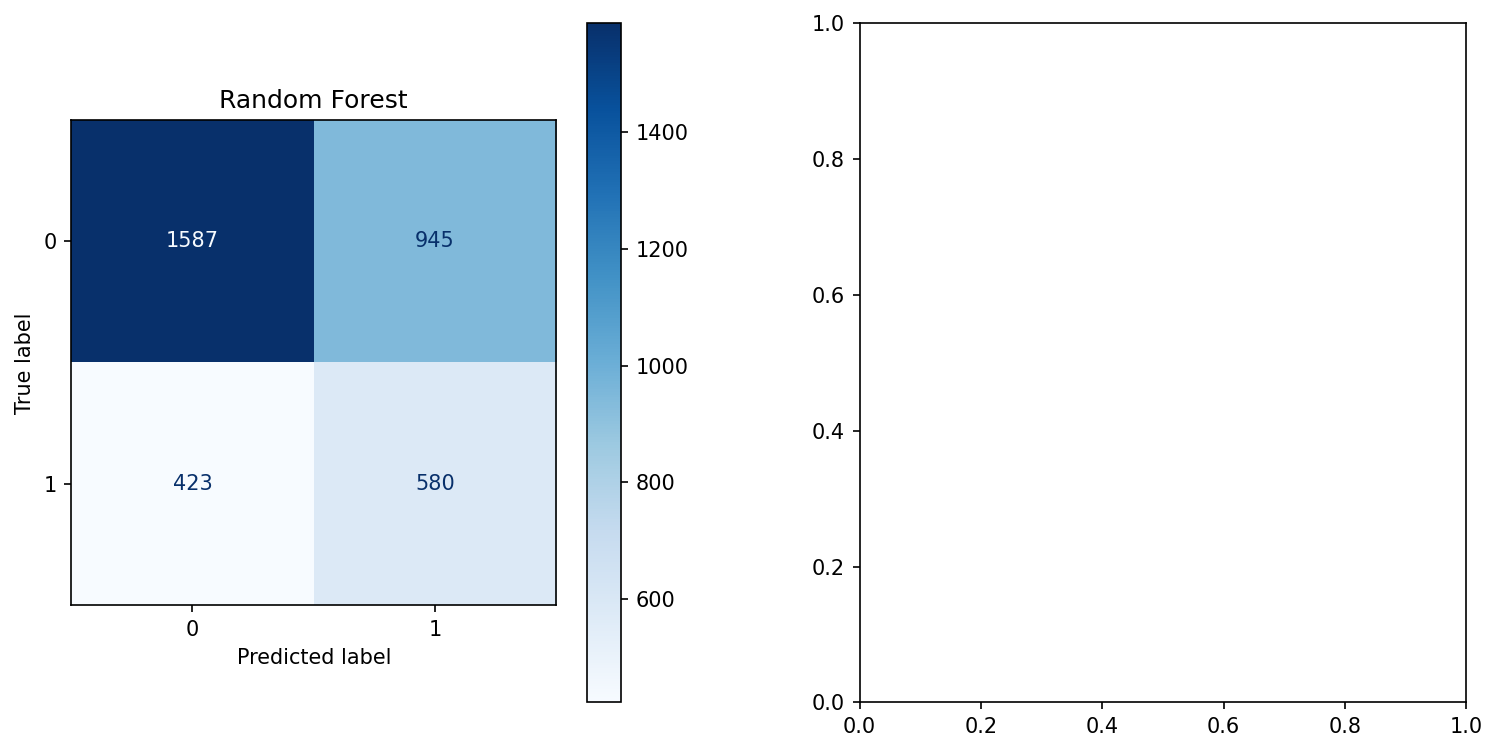

In [396]:
fig, axs = plt.subplots(1,2, figsize=(12,6), facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace=.3)

axs = axs.ravel()    
i = 0
for name, clf in zip(names, classifiers):


    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)

    cm=confusion_matrix(y_test,y_pred)
    print(cm)
    
    print(np.concatenate([np.round(cm[0]/np.sum(cm[0]),decimals = 3),np.round(cm[1]/np.sum(cm[1]),decimals = 3)]))
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues',ax=axs[i])

    axs[i].set_title(name)
    i+=1
#fig.savefig("confusionmatrix.pdf",
       #bbox_inches='tight',dpi=255,transparent=False,facecolor='white')    

In [629]:
clf = classifiers[0].fit(X_train,y_train)

In [646]:
test['prob'] = clf.predict_proba(X_test)[:,1]

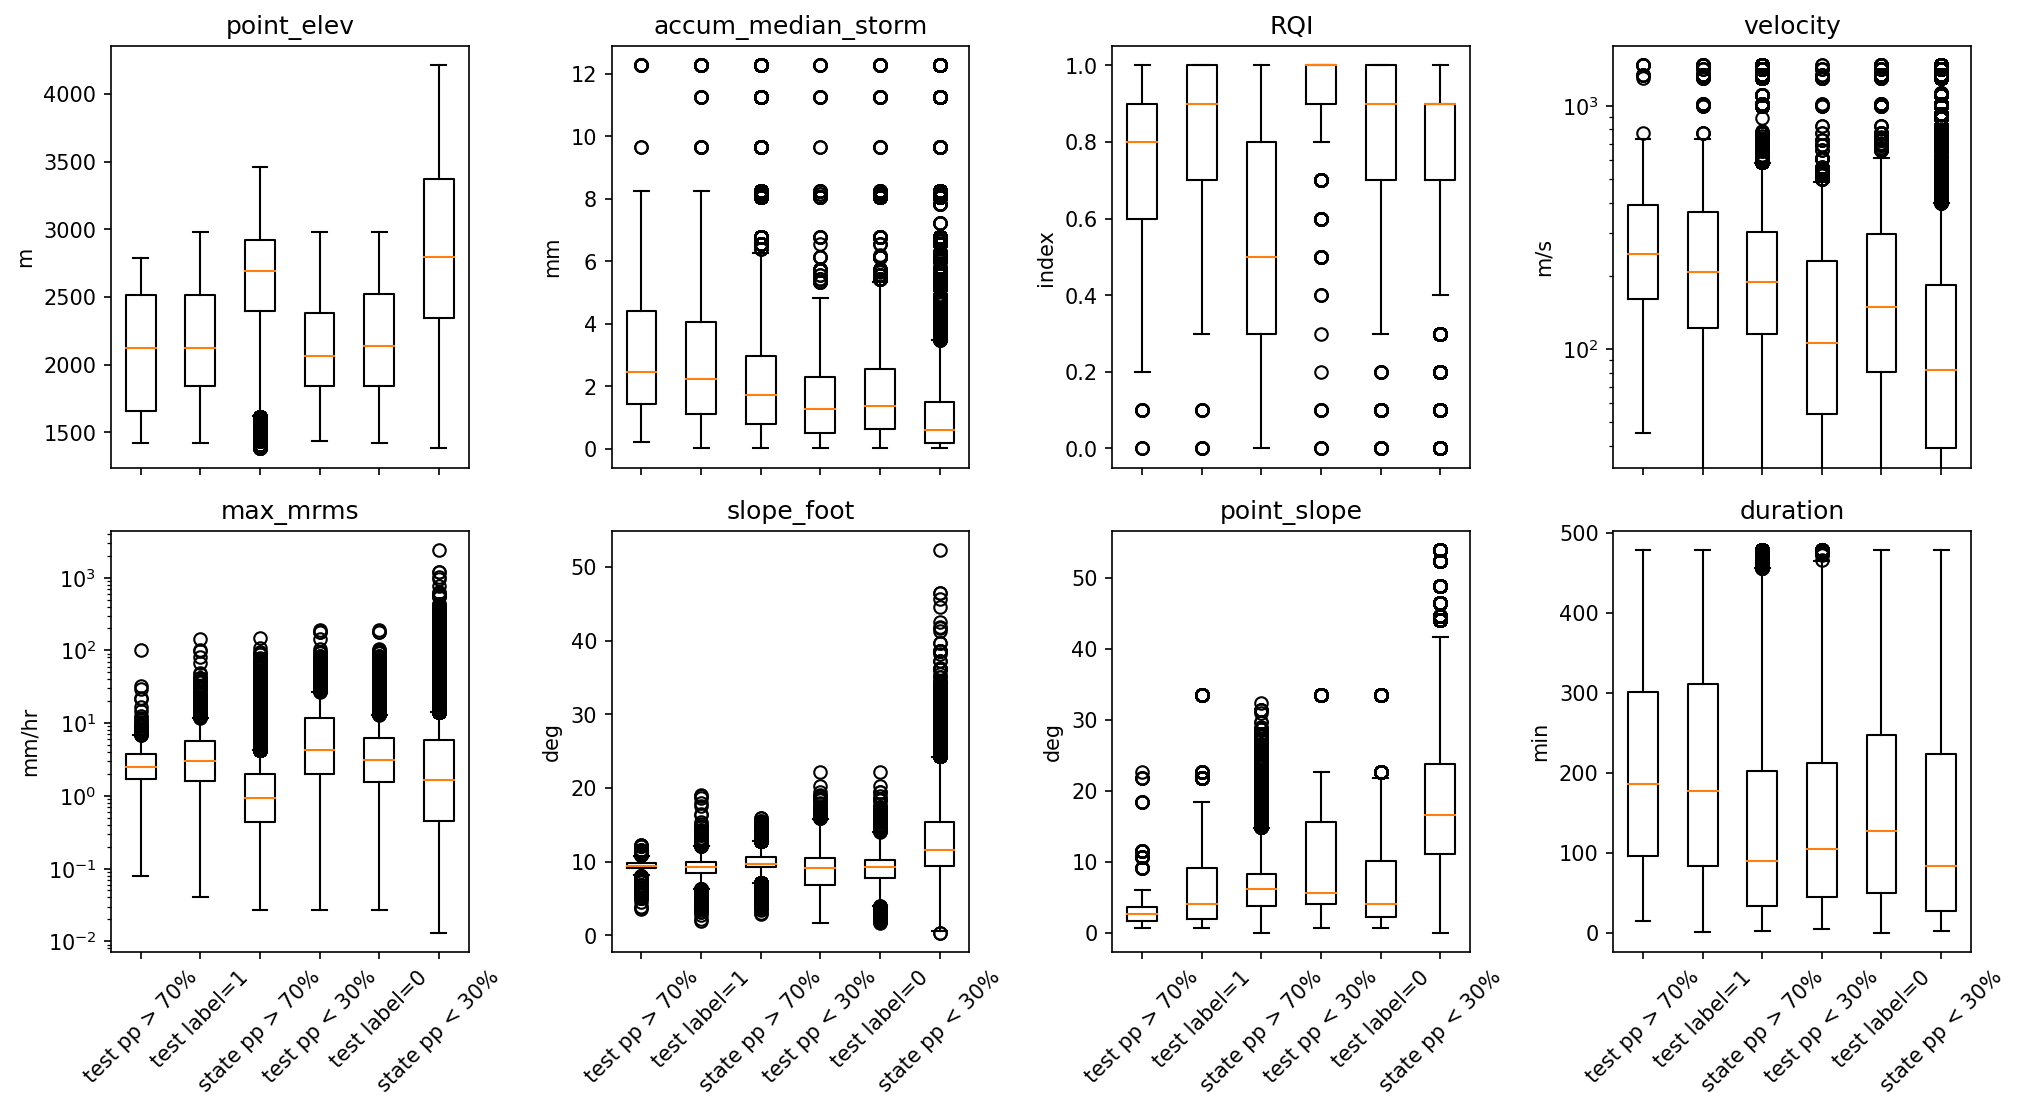

In [650]:
fig, axs = plt.subplots(2,4, figsize=(16,8), facecolor='w', edgecolor='k',sharex=True)
fig.subplots_adjust(hspace = .15, wspace=.4)

axs = axs.ravel()

state_good = predict.loc[predict.prob_rf>.7]
state_bad = predict.loc[predict.prob_rf<.3]

test_good = test.loc[test.prob>.7]
test_bad = test.loc[test.prob<.3]

labeled_good = test.loc[test.label==1]
labeled_bad = test.loc[test.label==0]

make_log = [3,4]
y_label = ['m','mm','index','m/s',
           'mm/hr','deg','deg','min']
title = ['total accum point','longitude','positive duration','latitude','elevation point',
        'storm duration', 'multi-sensor correction','aspect point','median storm accum', 'slope point',
        'median intensity point','storm major axis length','mean accum point','storm footprint slope','storm aspect']

for i in range(8):
    column = index[sorted_importances_idx][::-1][i]

    d = [test_good[column],labeled_good[column], state_good[column],test_bad[column],labeled_bad[column], state_bad[column]]
    axs[i].boxplot(d)
    axs[i].set_xticks([1,2,3,4,5,6],labels=['test pp > 70%', 'test label=1','state pp > 70%',
                                            'test pp < 30%', 'test label=0','state pp < 30%'],rotation=45)
    #axs[i].set_title(title[i])
    axs[i].set_title(column)
    test1 = np.isin(i,make_log)
    
    if test1 == True:
        axs[i].set_yscale('log')


    axs[i].set_ylabel(y_label[i])

    
fig.savefig("spread.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

In [15]:
# plot top 10 most important features after paramter tuning
clf = GradientBoostingClassifier(n_estimators=200, min_samples_split=3, min_samples_leaf=2,
                                 max_depth=6, learning_rate=0.05,random_state=0)

pipe = Pipeline([
("model", Thresholder(clf, threshold=0.7))
])
pipe.fit(X_train,y_train)

state_p = pipe.predict_proba(predict_s)
predict['label_neg'] = state_p[:,0]
predict['label_pos'] = state_p[:,1]

In [249]:
state_bad.max_mrms.max()

2404.8

9026
82174


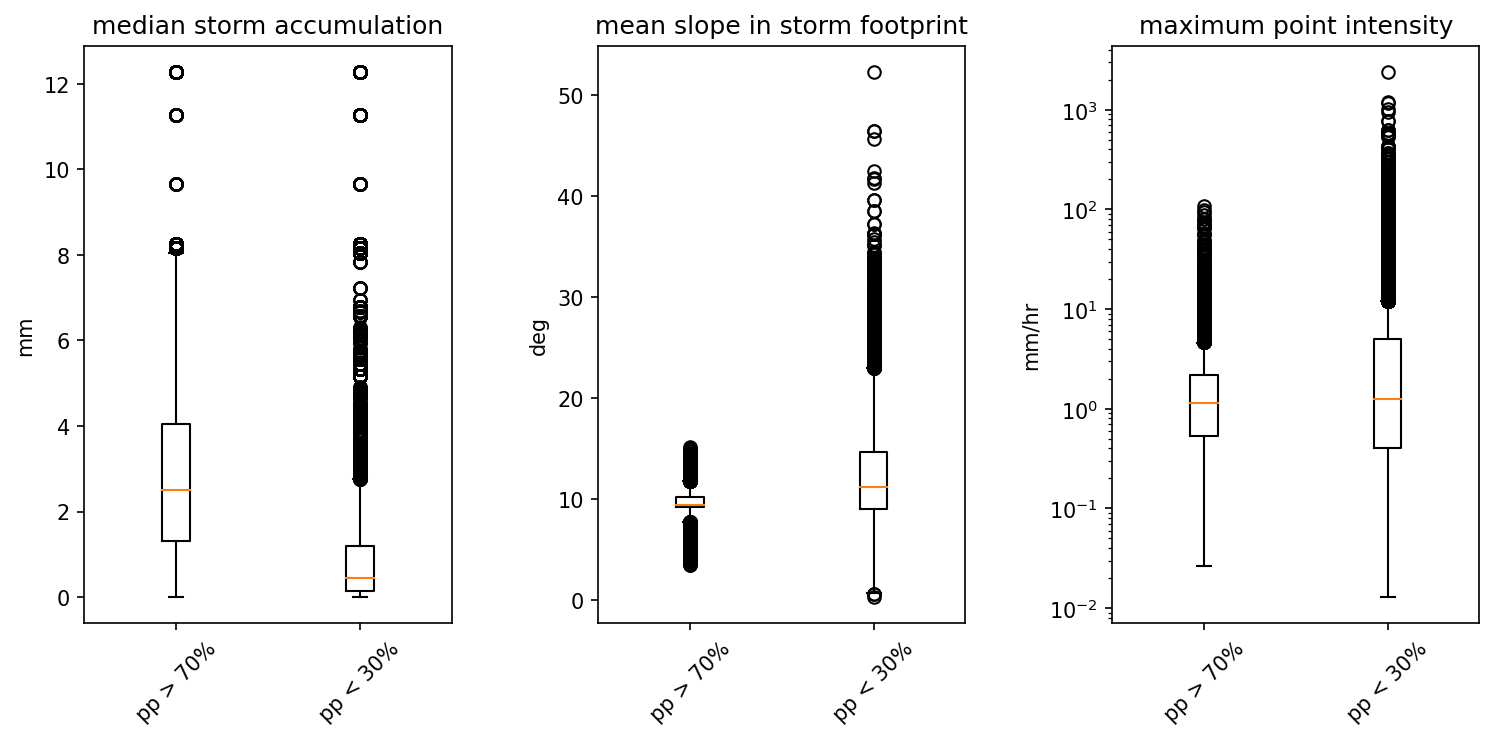

In [429]:
fig, axs = plt.subplots(1,3, figsize=(12,5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .32, wspace=.4)

axs = axs.ravel()

state_good = predict.loc[predict.prob_rf>.7]
print(len(state_good))
state_bad = predict.loc[predict.prob_rf<.3]
print(len(state_bad))

make_log = [0,6,10,12]
y_label = ['mm','min','m',
           'min','factor','deg','mm','deg',
           'mm/hr','km','mm','deg','deg']
title = ['total accum point','positive duration','elevation point',
        'storm duration', 'multi-sensor correction','aspect point','median storm accum', 'slope point',
        'median intensity point','storm major axis length','mean accum point','storm footprint slope','storm aspect']
#feature_importance_new = feature_importance.drop(index = ['latitude','longitude'])
y_label = ['mm','deg','mm/hr']
make_log = [2]
title =  ['median storm accumulation','mean slope in storm footprint','maximum point intensity']
fi = ['accum_median_storm', 'slope_foot','max_mrms']

for i in range(3):
    #column = feature_importance_new['Gradient Boosted'][0:3].index[i]
    
    ######COMENT IF MODEL CHANGES, UNCOMMENT IF NOT RUNNING FEATURE IMPORTANCE
    column = fi[i]
    
    d = [state_good[column],state_bad[column]]
    axs[i].boxplot(d)
    axs[i].set_xticks([1,2],labels=['pp > 70%','pp < 30%'],rotation=45)
    axs[i].set_title(title[i])
    test = np.isin(i,make_log)
    
    if test == True:
        axs[i].set_yscale('log')


    axs[i].set_ylabel(y_label[i])
    
fig.savefig("spread_extremes.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

In [237]:
high = df.loc[(df.mce>.6)&(df.total_accum_atgage>5)]
#low = df.loc[(df.mce<.5)&(df.mce>0)&(df.total_accum_atgage>10)]
low = df.loc[(df.mce<0)&(df.total_accum_atgage>5)].sample(n=len(high))

In [238]:
len(high)

145

In [239]:
high['label'] = 1
low['label'] = 0

c:\temp\3\ipykernel_41268\3692949699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high['label'] = 1


In [240]:
tsne = pd.concat([high,low])

In [241]:
tsne.columns

Index(['gage_id', 'mrms_accum_atgage', 'gage_accum', 'total_accum_atgage',
       'onoff', 'mce', 'max_mrms', 'latitude', 'longitude', 'median_int_point',
       'std_int_point', 'var_int_point', 'mean_int_point',
       'median_accum_point', 'std_accum_point', 'var_accum_point',
       'mean_accum_point', 'duration', 'month', 'hour', 'mult_correct', 'RQI',
       'point_elev', 'point_slope', 'max', 'std', 'var', 'mean', 'median',
       'storm_elev', 'elevation_foot', 'slope_foot', 'point_aspect',
       'storm_aspect', 'accum_mean_storm', 'accum_max_storm',
       'accum_median_storm', 'accum_std_storm', 'accum_var_storm',
       'duration_storm', 'area', 'axis_major_length', 'axis_minor_length',
       'eccentricity', 'velocity', 'label'],
      dtype='object')

In [242]:
data=scaler.fit_transform(tsne.drop(columns=['label','gage_id','mrms_accum_atgage', 'gage_accum','onoff', 'mce']))
t_sne = PCA(n_components=2,random_state=10)
S_t_sne = t_sne.fit_transform(data)

In [243]:
labels = tsne.label

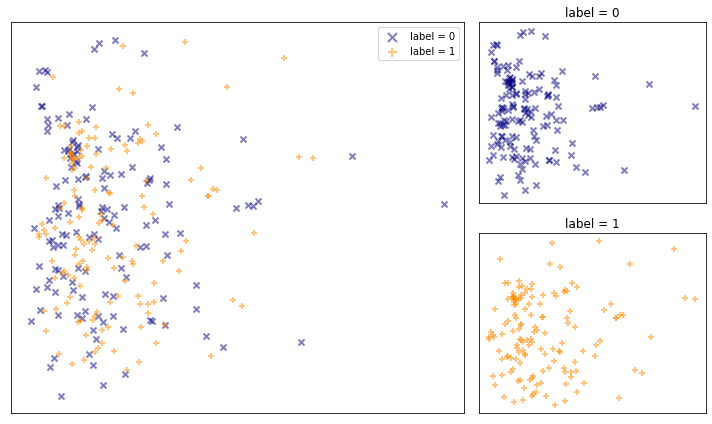

In [244]:
colors = ["navy", "darkorange","darkgreen" ]
markers=['x','+','*']

fig, axs = plt.subplots(ncols=2, nrows=2, gridspec_kw={'width_ratios': [2, 1]},figsize=(10,6))
gs = axs[0,1].get_gridspec()
# remove the underlying axes
for ax in axs[0:, 0]:
    ax.remove()
axbig = fig.add_subplot(gs[0:, 0])


for marker,color, i in zip(markers,colors, [0,1]):
    axbig.scatter(
        S_t_sne[labels == i, 0], S_t_sne[labels == i, 1],color=color, marker=marker,alpha=0.5, lw=2, label=i
    )
plt.legend(['label = 0','label = 1'],loc="best", shadow=False,scatterpoints=1,markerscale=1.5)
#plt.title("t-sne")

for marker,color, i in zip(markers,colors, [0]):
    axs[0,1].scatter(
        S_t_sne[labels == i, 0], S_t_sne[labels == i, 1],color="navy", marker='x',alpha=0.5, lw=2, label=i
    )
for marker,color, i in zip(markers,colors, [1]):
    axs[1,1].scatter(
        S_t_sne[labels == i, 0], S_t_sne[labels == i, 1],color="darkorange", marker='+',alpha=0.5, lw=2, label=i
    )
axbig.legend(['label = 0','label = 1'],loc="best", shadow=False,scatterpoints=1,markerscale=1.5)
axs[0,1].set_title('label = 0')
axs[1,1].set_title('label = 1')

axbig.set_xticks([])
axbig.set_yticks([])
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
axs[1,1].set_xticks([])
axs[1,1].set_yticks([])
fig.tight_layout()
fig.savefig("tsne.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

In [ ]:
'''# remove multiple gages in same MRMS grid
test = df.groupby(['latitude','longitude']).agg(list)
test['num_gage'] = [len(np.unique(test.gage_id[i])) for i in test.index]
test['i_gage'] = [np.unique(test.gage_id[i]) for i in test.index]

dup = test.loc[test.num_gage>1].reset_index().i_gage
gage_dup = [dup[i][1] for i in dup.index]
df = df.loc[~df.gage_id.isin(gage_dup)]'''

In [ ]:
# look at feature selection--all models
# look at cross folds not test

imp = []
all_values = []
for name, clf in zip(names, classifiers):
    
    r = []
    r_all_values = []
    for i in range(5):

        model = clf.fit(X_train[cv[i][0]],y_train[cv[i][0]]) 

        result = permutation_importance(
            model, X_train[cv[i][1]], y_train[cv[i][1]], n_repeats=10, random_state=42, n_jobs=2, scoring='average_precision'
        )

        r.append(result.importances_mean)
        r_all_values.append(result.importances)

    # get mean of importances across folds
    result = np.mean(r,axis=0)
    all_values.append(r_all_values)
        
    # save index where mean of folds of mean across repeats greater than zero
    importance_idx = []
    for i in result.argsort():
        if result[i] > 0:
            importance_idx.append(i)
    imp.append(importance_idx)'''


In [ ]:
# need to make lift match stratification
# don't think i have enough data for this
'''# look at how lift improves results
# lift 
lift_neg = 5
lift_pos = 95

f1 = []
precision = []
recall = []
for name, clf,k in zip(names, classifiers,j):
    feature_drop = imp.iloc[k].dropna().astype('int').values
    
    f = []
    p = []
    r = []

    for i in range(5):
        try:
            clf.fit(X_train[cv[i][0]][:,feature_drop],y_train[cv[i][0]]) 
            
            y_prob = clf.predict_proba(X_train[cv[i][1]][:,feature_drop])[:,1]
        
            # find lowest and highest quantiles for probability
            low = np.percentile(y_prob,lift_neg)
            high = np.percentile(y_prob,lift_pos)
            
            lift_idx = np.argwhere((y_prob>high)|(y_prob<low))
        
            y_prob_lift = y_prob[lift_idx]
            y_pred_lift = clf.predict(X_train[cv[i][1]][:,feature_drop])[lift_idx]
            print(Counter(y_pred_lift[:,0]))
            
            PrecisionRecallDisplay.from_predictions(y_train[cv[i][1]][lift_idx][:,0], y_prob_lift[:,0],name=name+str(i))
            plt.show()
            f.append(f1_score(y_train[cv[i][1]][lift_idx],y_pred_lift))
            p.append(precision_score(y_train[cv[i][1]][lift_idx],y_pred_lift))
            r.append(recall_score(y_train[cv[i][1]][lift_idx],y_pred_lift))
        except ValueError:
            break

    f1.append([name,np.mean(f), np.std(f)])
    precision.append([name,np.mean(p), np.std(p)])
    recall.append([name,np.mean(r), np.std(r)])'''



In [ ]:
# plot top 10 most important features after paramter tuning

# sort df and predict by order of feature importance

fig, axs = plt.subplots(3,5, figsize=(16,14), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .32, wspace=.4)

axs = axs.ravel()

clf = GradientBoostingClassifier(n_estimators=200, min_samples_split=3, min_samples_leaf=2,
                                 max_depth=6, learning_rate=0.05,random_state=0)

pipe = Pipeline([
("model", Thresholder(clf, threshold=0.7))
])
pipe.fit(X_train,y_train)

state_p = pipe.predict(predict_s)
predict['label'] = state_p
state_good = predict.loc[predict.label==1]
state_bad = predict.loc[predict.label==0]

train_good = df.loc[df.label==1]
train_bad = df.loc[df.label==0]

make_log = [0,6,10,12]
y_label = ['mm','deg','min','deg','m',
           'min','factor','deg','mm','deg',
           'mm/hr','km','mm','deg','deg']
title = ['total accum point','longitude','positive duration','latitude','elevation point',
        'storm duration', 'multi-sensor correction','aspect point','median storm accum', 'slope point',
        'median intensity point','storm major axis length','mean accum point','storm footprint slope','storm aspect']

for i in range(15):
    column = feature_importance['Gradient Boosting'][0:15].index[i]

    d = [train_good[column],state_good[column],train_bad[column],state_bad[column]]
    axs[i].boxplot(d)
    axs[i].set_xticks([1,2,3,4],labels=['train good', 'state good','train bad','state bad'],rotation=45)
    axs[i].set_title(title[i])
    test = np.isin(i,make_log)
    
    if test == True:
        axs[i].set_yscale('log')


    axs[i].set_ylabel(y_label[i])
    
fig.savefig("spread.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(18,14), facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace=.3)

axs = axs.ravel() 
j=0

for name, clf in zip(names, classifiers):
    for i in range(3):
        if i == 0:
            clf.fit(X_train,y_train)

            y_prob = clf.predict_proba(X_test)[:, 1]

            prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
            mse = mean_squared_error(prob_true,prob_pred)
            axs[j].plot(prob_pred,prob_true,label=name+' , uncalibrated'+', mse: '+str(mse)[0:6])
        elif i == 1:
            cal = CalibratedClassifierCV(clf, cv=cv)
            cal.fit(X_train,y_train)

            y_prob = cal.predict_proba(X_test)[:, 1]

            prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
            mse = mean_squared_error(prob_true,prob_pred)
            axs[j].plot(prob_pred,prob_true,label=name+' , sigmoid'+', mse: '+str(mse)[0:6])

        elif i == 2:
            cal = CalibratedClassifierCV(clf, cv=cv,method='isotonic')
            cal.fit(X_train,y_train)

            y_prob = cal.predict_proba(X_test)[:, 1]

            prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
            mse = mean_squared_error(prob_true,prob_pred)
            axs[j].plot(prob_pred,prob_true,label=name+' , isotonic'+', mse: '+str(mse)[0:6])
            
            
    axs[j].plot(prob_true,prob_true,'--k',label='perfectly calibrated')
    axs[j].legend()
    axs[j].axis("square")
    axs[j].set_xlabel('mean predicted probability for positive')
    axs[j].set_ylabel('fraction of positives')
    j+=1
fig.savefig("calibration.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')fig, axs = plt.subplots(1,3, figsize=(18,14), facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace=.3)

axs = axs.ravel() 
j=0

for name, clf in zip(names, classifiers):
    for i in range(3):
        if i == 0:
            clf.fit(X_train,y_train)

            y_prob = clf.predict_proba(X_test)[:, 1]

            prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
            mse = mean_squared_error(prob_true,prob_pred)
            axs[j].plot(prob_pred,prob_true,label=name+' , uncalibrated'+', mse: '+str(mse)[0:6])
        elif i == 1:
            cal = CalibratedClassifierCV(clf, cv=cv)
            cal.fit(X_train,y_train)

            y_prob = cal.predict_proba(X_test)[:, 1]

            prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
            mse = mean_squared_error(prob_true,prob_pred)
            axs[j].plot(prob_pred,prob_true,label=name+' , sigmoid'+', mse: '+str(mse)[0:6])

        elif i == 2:
            cal = CalibratedClassifierCV(clf, cv=cv,method='isotonic')
            cal.fit(X_train,y_train)

            y_prob = cal.predict_proba(X_test)[:, 1]

            prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
            mse = mean_squared_error(prob_true,prob_pred)
            axs[j].plot(prob_pred,prob_true,label=name+' , isotonic'+', mse: '+str(mse)[0:6])
            
            
    axs[j].plot(prob_true,prob_true,'--k',label='perfectly calibrated')
    axs[j].legend()
    axs[j].axis("square")
    axs[j].set_xlabel('mean predicted probability for positive')
    axs[j].set_ylabel('fraction of positives')
    j+=1
fig.savefig("calibration.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(16,12), facecolor='w', edgecolor='k')
fig.subplots_adjust(wspace=.3)

axs = axs.ravel() 
j=0
for name, clf in zip(names, classifiers):
    mean_t = np.linspace(0, 1, 1500)
    ap = []
    r = []
    p = []
    for i in range(5):
        model = clf.fit(X_train[cv[i][0]],y_train[cv[i][0]]) 
        y_prob = model.predict_proba(X_train[cv[i][1]])[:,1]
        precision, recall, thresholds = precision_recall_curve(y_train[cv[i][1]], y_prob)
        p.append(np.interp(mean_t, thresholds, precision[:-1]))
        r.append(np.interp(mean_t, thresholds, recall[:-1]))
        
        ap.append(average_precision_score(y_train[cv[i][1]], y_prob))

    mean_p = np.mean(p, axis=0)
    std_p = np.std(p, axis=0)
    mean_r = np.mean(r, axis=0)
    std_r = np.std(r, axis=0)
    mean_ap = np.mean(ap)
    
    std_ap = np.std(ap)
    print(mean_ap)
    print(std_ap)
    axs[j].plot(mean_t,mean_p,label='mean validation precision', color='cornflowerblue',linestyle='--')
    axs[j].plot(mean_t,mean_r,label='mean validation recall',color='darkred',linestyle='--')

    clf = clf.fit(X_train,y_train)
    y_prob = clf.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    axs[j].plot(thresholds,precision[:-1],label='test precision', color='darkblue')
    axs[j].plot(thresholds,recall[:-1],label='test recall',color='darkred')
    
    axs[j].axis("square")
    axs[j].set_title(name)
    axs[j].set_xlabel("threshold")
    axs[j].set_ylabel("precision/recall")

    p_upper = np.minimum(mean_p + std_p, 1)
    p_lower = np.maximum(mean_p - std_p, 0)
    axs[j].fill_between(
        mean_t,
        p_lower,
        p_upper,
        color="cornflowerblue",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev."+'precision',
    )

    r_upper = np.minimum(mean_r + std_r, 1)
    r_lower = np.maximum(mean_r - std_r, 0)
    axs[j].fill_between(
        mean_t,
        r_lower,
        r_upper,
        color="darkred",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev."+'recall',
    )
    axs[j].legend(loc="lower left")
    j+=1
fig.savefig("PR.pdf",
       bbox_inches='tight',dpi=255,transparent=False,facecolor='white')